In [1]:
from utility import *
import warnings
warnings.filterwarnings('ignore') 
import mlflow

In [2]:
import pandas as pd 
import numpy as np

train = pd.read_csv('datasets\\sds\\train_04.csv')
test = pd.read_csv('datasets\\sds\\test_04.csv')
train.head()
print(train.iloc[3]['text'])

Email von einer Kollegin. Gestern, gemeinsam mit Freunden beim Grillen. Aufstehen und beginnen zu arbeiten. Alles funktioniert und es macht Spaß. Veränderung des Verhaltens der Menschen durch die Pandemie. Aufgaben verteilen. lustig, ungezwungen


In [3]:
y_train = np.where(train.extra_bin.values == 1, 1, 0)
y_test = np.where(test.extra_bin.values == 1, 1, 0)
print(y_train)
#Best Parameters : {'alpha': 1, 'l1_ratio': 0.15, 'penalty': 'l2'}

[1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1
 0 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1]


In [4]:
from featurization_pymagnitude_xlmr_sentiment import *

print("\n\n---- Getting pymagnitude embeddings with xlmr sentiment model ----")
train_features_pm_xlmr, test_features_pm_xlmr, feature_names_pm_xlmr = featurization_pymagnitude_xlmr_sentiment(train, test, 'tfidf_glove')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!




---- Getting pymagnitude embeddings with xlmr sentiment model ----
Emoji re....
Num dots....
Punctuation....
Sentiment Scores....
XLMR Sentiment Model took --- 20.570101022720337 seconds ---
Text Features....
Pymagnitude.....
Pymagnitude model load took --- 0.00247955322265625 seconds ---


2023/04/08 18:01:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

2023/04/08 18:01:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Pymagnitude Framework took --- 6.6806206703186035 seconds ---


2023/04/08 18:01:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


--- Normalized-features:
[[0.62882921 0.57895593 0.49701685 ... 0.54537616 0.57900959 0.38768693]
 [0.50755797 0.20770079 0.6208735  ... 0.37141341 0.57197655 0.36902082]
 [0.52357246 0.71562488 0.56267328 ... 0.64947906 0.71248297 0.10302208]
 ...
 [0.         0.59411483 0.57789967 ... 0.         0.97384943 0.24835512]
 [0.41829611 0.58404286 0.24840145 ... 0.49984046 0.31019643 0.        ]
 [0.5869989  0.42290812 0.64402693 ... 0.58942267 0.54180446 0.56389707]]
DONE!


### SFS (Sequential Forward Selection)
Finally, let's try SFS - which does the same thing as RFE instead adds features sequentially. SFS starts with 0 features and adds features 1-by-1 in each loop in a greedy manner. One small difference is that SFS solely uses the feature sets performance on the CV set as a metric for selecting the best features, unlike RFE which used model weights (feature_importances_)

In [5]:
# Note: MLxtend provides the SFS Implementation
from mlxtend.feature_selection import SequentialFeatureSelector
# Since we have a hold out Test set that we would like to use - Let's create a `PredefinedSplit`
from sklearn.model_selection import PredefinedSplit

def run_sf_selection(train_features, test_features, y_train, y_test, feature_names):
    X = sparse.vstack((train_features, test_features))
    test_fold = [-1 for _ in range(train_features.shape[0])] + [0 for _ in range(test_features.shape[0])]     # We need to label -1 for the train set and 0 for test set
    y = np.concatenate([y_train, y_test])
    ps = PredefinedSplit(test_fold)
    
    log_reg = SGDClassifier(loss = 'log', alpha = 1e-2)

    selector = SequentialFeatureSelector(log_reg, k_features = 'best', floating = True, cv = ps, scoring = 'f1', verbose = 1, n_jobs = -1) # k_features = 'best' returns the best subset of features
    selector.fit(X.tocsr(), y)
    
    # Now lets select the best features and check the performance
    train_features_selected = selector.transform(train_features.tocsr())
    test_features_selected = selector.transform(test_features.tocsr())
    print(train_features_selected)
    
    
    log_reg = run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)
    
    log_reg.fit(train_features_selected, y_train)
    y_pred_prob = (log_reg.predict_proba(test_features_selected)[:,1])

    f1, best_precision, best_recall, roc_auc, acc, threshold = print_model_metrics(y_test, y_pred_prob, confusion = True, return_metrics = True)
    
    mlflow.end_run()
    with mlflow.start_run():
        mlflow.log_param("model_type", "LogisticRegression")
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", best_precision)
        mlflow.log_metric("recall", best_recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("threshold", threshold)

        # Log the model
        mlflow.sklearn.log_model(log_reg, "extraversion_classifier")
        mlflow.sklearn.log_model(selector, "extraversion_selector")
    
    return selector, log_reg

## Pymagnitude with xlmr sentiment

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 309 out of 309 | elapsed:    2.5s finished
Features: 1/309[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 308 out of 308 | elapsed:    0.2s finished
Features: 2/309[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 307 out of 307 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/309[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: D

  (0, 0)	0.5294117647058824
  (0, 1)	0.25825856628272503
  (0, 2)	0.1549947562808054
  (0, 3)	0.6288292096650043
  (0, 4)	0.5789559305085006
  (0, 5)	0.8559905034282391
  (0, 6)	0.1085985826020639
  (0, 7)	0.3603307243771267
  (0, 8)	0.5634232718355057
  (0, 9)	0.490995828263491
  (0, 10)	0.1542601366028057
  (0, 11)	0.45920841258262385
  (0, 12)	0.4305648810679219
  (0, 13)	0.4366066240027669
  (0, 14)	0.3833087889372232
  (0, 15)	0.6022973286205395
  (0, 16)	0.5919121928601078
  (0, 17)	0.24495489385597738
  (0, 18)	0.3169189206883406
  (0, 19)	0.37565837068597285
  (0, 20)	0.16845095905839907
  (0, 21)	0.280326212390716
  (0, 22)	0.8606557091398082
  (0, 23)	0.36035871292075705
  (0, 24)	0.5475557207479168
  :	:
  (55, 4)	0.42290811816649443
  (55, 5)	0.3621363257635944
  (55, 6)	0.665894239746977
  (55, 7)	0.37455499681294474
  (55, 8)	0.5175550150258468
  (55, 9)	0.684264334928206
  (55, 10)	0.16757815922619135
  (55, 11)	0.010152787788652418
  (55, 12)	0.4245049902215355
  (55, 1

2023/04/08 18:06:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


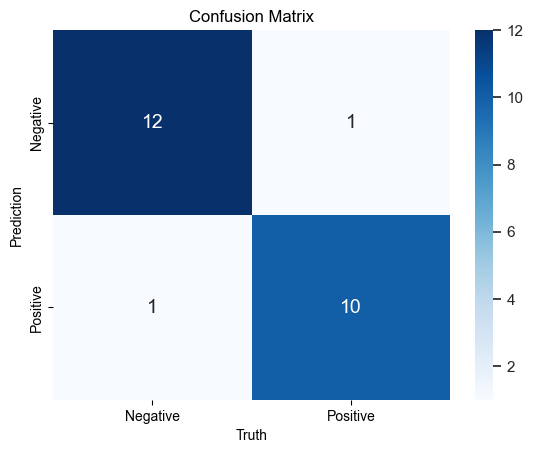

In [6]:
selector, logreg = run_sf_selection(train_features_pm_xlmr, test_features_pm_xlmr, y_train, y_test, feature_names_pm_xlmr)

Superb! We have the best accuracy with the fastest embedding model and the fastest sentiment model!!

## Save best classifier model

In [7]:
import joblib
selector_file = 'extraversion_sf_selector2.joblib'
log_reg_file = 'extraversion_classifier2.joblib'
joblib.dump(selector, selector_file)
joblib.dump(logreg, log_reg_file)


['extraversion_classifier2.joblib']

In [8]:
mlflow.sklearn.log_model(selector, "extraversion_selector")
mlflow.sklearn.log_model(logreg, "extraversion_classifier")

2023/04/08 18:06:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
